#### Covid-19 detection using VGG16
Python · SARS-COV-2 Ct-Scan Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
import cv2
import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.layers import Input
#from keras.models import Model, Input
from keras.layers import Dense,Conv2D,Dropout,BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import  ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16

# Supress info, warnings and error messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
disease_types = ['COVID', 'non-COVID']

train_dir = data_dir = 'dataset'

train_data = []

for index, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append([sp + "/" + file, index, sp])
        
train = pd.DataFrame(train_data, columns = ['File', 'ID','Disease Type'])
train

,File,ID,Disease Type
0,COVID/Covid (1).png,0,COVID
1,COVID/Covid (10).png,0,COVID
2,COVID/Covid (100).png,0,COVID
3,COVID/Covid (1000).png,0,COVID
4,COVID/Covid (1001).png,0,COVID
...,...,...,...
2468,non-COVID/Non-Covid (995).png,1,non-COVID
2469,non-COVID/Non-Covid (996).png,1,non-COVID
2470,non-COVID/Non-Covid (997).png,1,non-COVID
2471,non-COVID/Non-Covid (998).png,1,non-COVID


Text(0.5, 1.0, 'Frequency Histogram of Disease IDs')

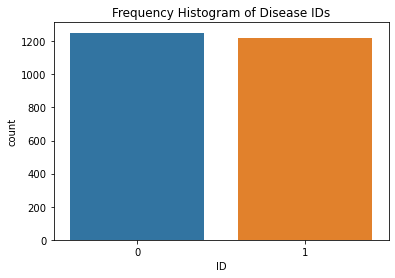

In [4]:
Seed = 7
IMAGE_SIZE = 224
train = train.sample(frac = 1, replace=False, random_state = Seed) 
train = train.reset_index(drop = True) # Reset indices (row numbers)

sns.countplot(x = "ID", data = train).set_title("Frequency Histogram of Disease IDs")

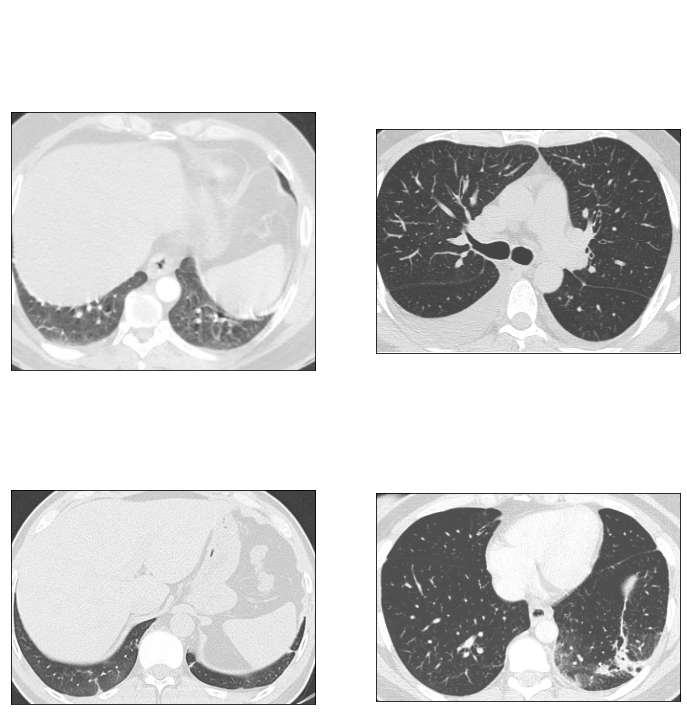

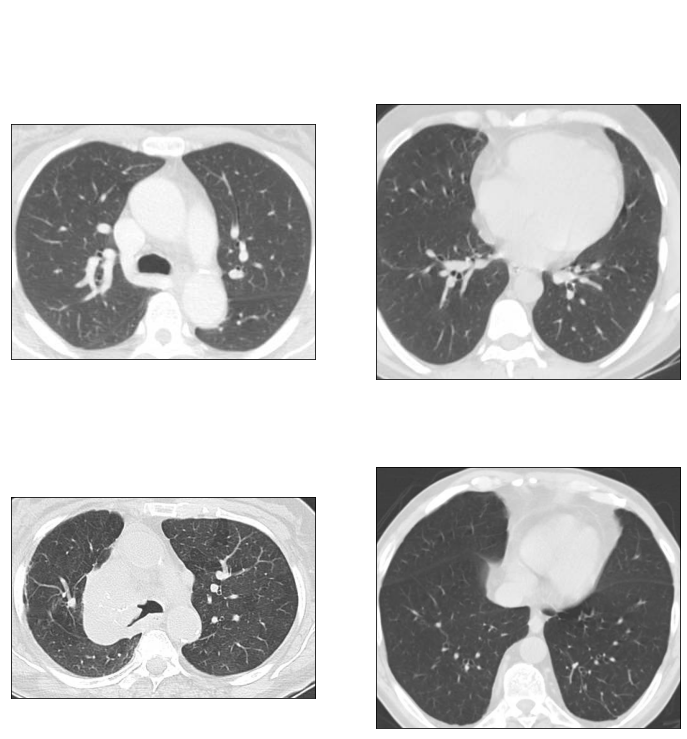

In [5]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    
    n = 0
    fig.suptitle(defect_types, fontsize = 22, color = "white")
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
            
# Displays first n images of class from training set
plot_defects('COVID', 2, 2)
plot_defects('non-COVID', 2, 2)

In [6]:
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag

# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [7]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in enumerate(train['File'].values):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

# Normalize the data
X_Train = X_train / 255.0
print('Train Shape:', X_Train.shape)

Y_train = to_categorical(train['ID'].values, num_classes = 2)

Train Shape: (2473, 224, 224, 3)


In [8]:
# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train,
                                                  Y_train,
                                                  test_size = 0.2,
                                                  random_state = Seed)

print(f'X_train:',X_train.shape)
print(f'X_val:',X_val.shape)
print(f'Y_train:',Y_train.shape)
print(f'Y_val:',Y_val.shape)

X_train: (1978, 224, 224, 3)
X_val: (495, 224, 224, 3)
Y_train: (1978, 2)
Y_val: (495, 2)


In [11]:
from keras.models import Model


def build_vgg(IMAGE_SIZE, channels):
    
    VGG = VGG16(weights='imagenet', include_top = False)
    
    input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, channels))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = VGG(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)

    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)

    output = Dense(2,activation = 'softmax')(x)
 

    # model
    model = Model(input,output)
   
    
    optimizer = Adam(learning_rate= 0.003, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0)
    model.compile(loss = 'categorical_crossentropy', optimizer =optimizer, metrics = ['accuracy'])
    model.summary()
    
    return model

In [12]:
channels = 3

model = build_vgg(IMAGE_SIZE, channels)
annealer = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.70, patience = 5, verbose = 1, min_lr = 1e-4)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range = 360, # Degree range for random rotations
                        width_shift_range = 0.2, # Range for random horizontal shifts
                        height_shift_range = 0.2, # Range for random vertical shifts
                        zoom_range = 0.2, # Range for random zoom
                        horizontal_flip = True, # Randomly flip inputs horizontally
                        vertical_flip = True) # Randomly flip inputs vertically

datagen.fit(X_train)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 3)       84        
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 32)                1641

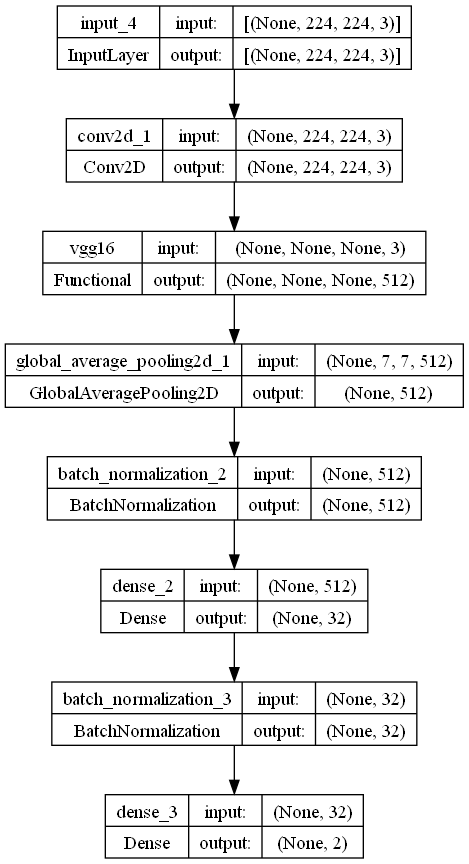

In [12]:
!pip install pydot
from tensorflow.keras.utils import plot_model

plot_model(model, to_file = 'convnet.png', show_shapes = True, show_layer_names = True)

In [13]:
BATCH_SIZE = 32
EPOCHS = 65


# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE),
               steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
               epochs = EPOCHS,q
               verbose = 1,
               callbacks = [annealer],
               validation_data = (X_val, Y_val))

Epoch 1/65
61/61 [==============================] - 2018s 33s/step - loss: 0.6533 - accuracy: 0.6608 - val_loss: 13.0594 - val_accuracy: 0.5010 - lr: 0.0030
Epoch 2/65
61/61 [==============================] - 2035s 33s/step - loss: 0.4684 - accuracy: 0.7826 - val_loss: 4.0606 - val_accuracy: 0.5010 - lr: 0.0030
Epoch 3/65
61/61 [==============================] - 2221s 36s/step - loss: 0.4054 - accuracy: 0.8176 - val_loss: 11.6229 - val_accuracy: 0.5010 - lr: 0.0030
Epoch 4/65
61/61 [==============================] - 2120s 35s/step - loss: 0.3933 - accuracy: 0.8258 - val_loss: 4.9497 - val_accuracy: 0.5010 - lr: 0.0030
Epoch 5/65
61/61 [==============================] - 2011s 33s/step - loss: 0.3977 - accuracy: 0.8299 - val_loss: 0.7931 - val_accuracy: 0.6202 - lr: 0.0030
Epoch 6/65
61/61 [==============================] - 2014s 33s/step - loss: 0.3933 - accuracy: 0.8284 - val_loss: 7.5479 - val_accuracy: 0.4990 - lr: 0.0030
Epoch 7/65
61/61 [==============================] - 2015s 33s/

Epoch 48/65
61/61 [==============================] - 2001s 33s/step - loss: 0.1853 - accuracy: 0.9229 - val_loss: 0.3724 - val_accuracy: 0.8687 - lr: 5.0421e-04
Epoch 49/65
61/61 [==============================] - 2003s 33s/step - loss: 0.1911 - accuracy: 0.9239 - val_loss: 0.6537 - val_accuracy: 0.8061 - lr: 5.0421e-04
Epoch 50/65
61/61 [==============================] - ETA: 0s - loss: 0.1990 - accuracy: 0.9239 
Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0003529469657223671.
61/61 [==============================] - 2001s 33s/step - loss: 0.1990 - accuracy: 0.9239 - val_loss: 0.1631 - val_accuracy: 0.9374 - lr: 5.0421e-04
Epoch 51/65
61/61 [==============================] - 1998s 33s/step - loss: 0.1800 - accuracy: 0.9291 - val_loss: 0.2679 - val_accuracy: 0.8949 - lr: 3.5295e-04
Epoch 52/65
61/61 [==============================] - 1993s 33s/step - loss: 0.1835 - accuracy: 0.9275 - val_loss: 0.3813 - val_accuracy: 0.8364 - lr: 3.5295e-04
Epoch 53/65
61/61 [===============

In [14]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 123s 8s/step - loss: 0.4185 - accuracy: 0.8444
Final Loss: 0.4184710383415222, Final Accuracy: 0.8444444537162781


16/16 [==============================] - 127s 8s/step


Text(0.5, 145.31999999999996, 'Predicted')

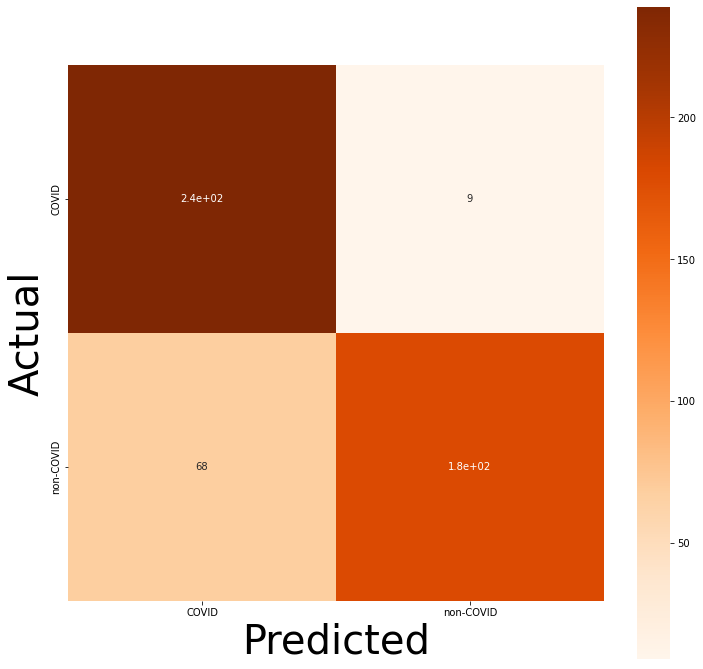

In [15]:
Y_pred = model.predict(X_val)
Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Oranges, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

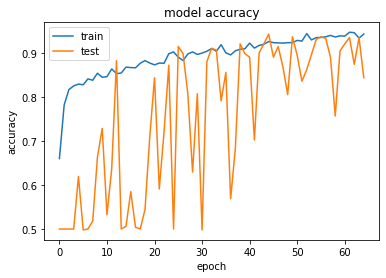

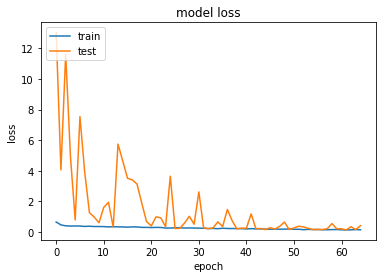

In [16]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:

## Summary Statistics
TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
precision = TP / (TP+FP) # % positive out of all predicted positives
recall =  TP / (TP+FN) # % positive out of all supposed to be positives
specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary